In [2]:
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import STOPWORDS as stopwords_wc
import re
import numpy as np

In [30]:
df = None
folderpath = "../../Data/QMEF/ILIAS_Elon_Musk_Tweets/"

In [42]:
# Some tweets are longer than one line. The line break character \n gets misinterpreted as new tweet. Replace all \n with white space but the first one.
for filename in os.listdir(folderpath):
    with open(os.path.join(folderpath,filename), 'r', encoding='latin1') as file:
        before, first, after = file.read().partition('\n')
        result = before + first + after.replace('\n', ' ')
    with open(os.path.join(folderpath,filename), 'w', encoding='latin1') as file:
        file.write(result)

In [43]:
# Iterate through all tweets and append them to a pandas DataFrame
# Could use further optimization - Runtime 10 seconds.
for filename in os.listdir(folderpath):
    df = pd.concat([df, pd.read_csv(os.path.join(folderpath,filename), encoding='utf8', sep='\t')], axis=0)

In [46]:
# Correcting the Data Types
df['UTC'] = pd.to_datetime(df['UTC'], utc=True)
df['CreatedAt'] = pd.to_datetime(df['CreatedAt'], utc=True)
df['Text'] = df['Text'].apply(lambda x: str(x))
df.dtypes

TweetId                         int64
Text                           object
Name                           object
ScreenName                     object
UTC               datetime64[ns, UTC]
CreatedAt         datetime64[ns, UTC]
Favorites                       int64
Retweets                        int64
Language                       object
Client                         object
TweetType                      object
URLs                           object
Hashtags                        int64
Mentions                        int64
MediaType                      object
MediaURLs                      object
neg                           float64
pos                           float64
neu                           float64
compound                      float64
crypto related                 object
year                          float64
dtype: object

In [47]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    vs = analyzer.polarity_scores(text)
    return [vs['neg'], vs['pos'], vs['neu'], vs['compound']]

df[['neg', 'pos', 'neu', 'compound']] = df.apply(lambda x: get_sentiment(str(x['Text'])),result_type='expand', axis=1)

In [55]:
keywords = ['doge', 'crypto', 'cryptocurrency', 'cryptocurrencies', 'bitcoin', 'btc', 'etherium', 'coin','invest']
doge_keywords = ['doge']

def get_crypto_boolean(text):
    text = text.lower()
    text = re.sub(r"@\w*", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    if any(word in text for word in doge_keywords):
        return True
    return False

df['crypto related'] = df.apply(lambda x: get_crypto_boolean(str(x['Text'])), result_type='expand', axis = 1)

# Extra column for the year
df['year'] = df["UTC"].apply(lambda x: int(str(x).split("-")[0]))

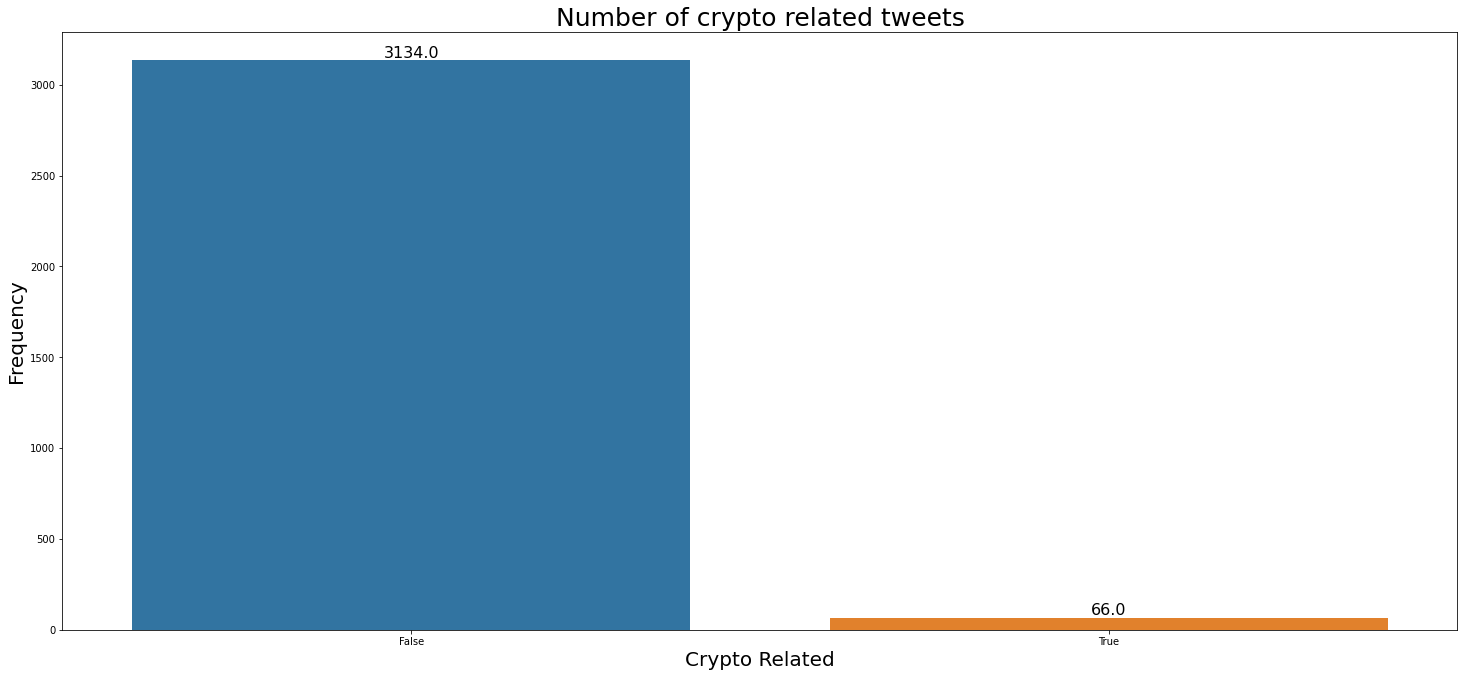

In [56]:
# Crypto related
date_count_df = df.groupby('crypto related')["TweetId"].count().reset_index()

# Plot
plt.figure(figsize=(25, 11))
ax = sns.barplot(data=date_count_df, x='crypto related', y="TweetId")
plt.title("Number of crypto related tweets", size=25)
plt.xlabel("Crypto Related", size=20)
plt.ylabel("Frequency", size=20)

# Add annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=16)

plt.show()

[2020 2021]


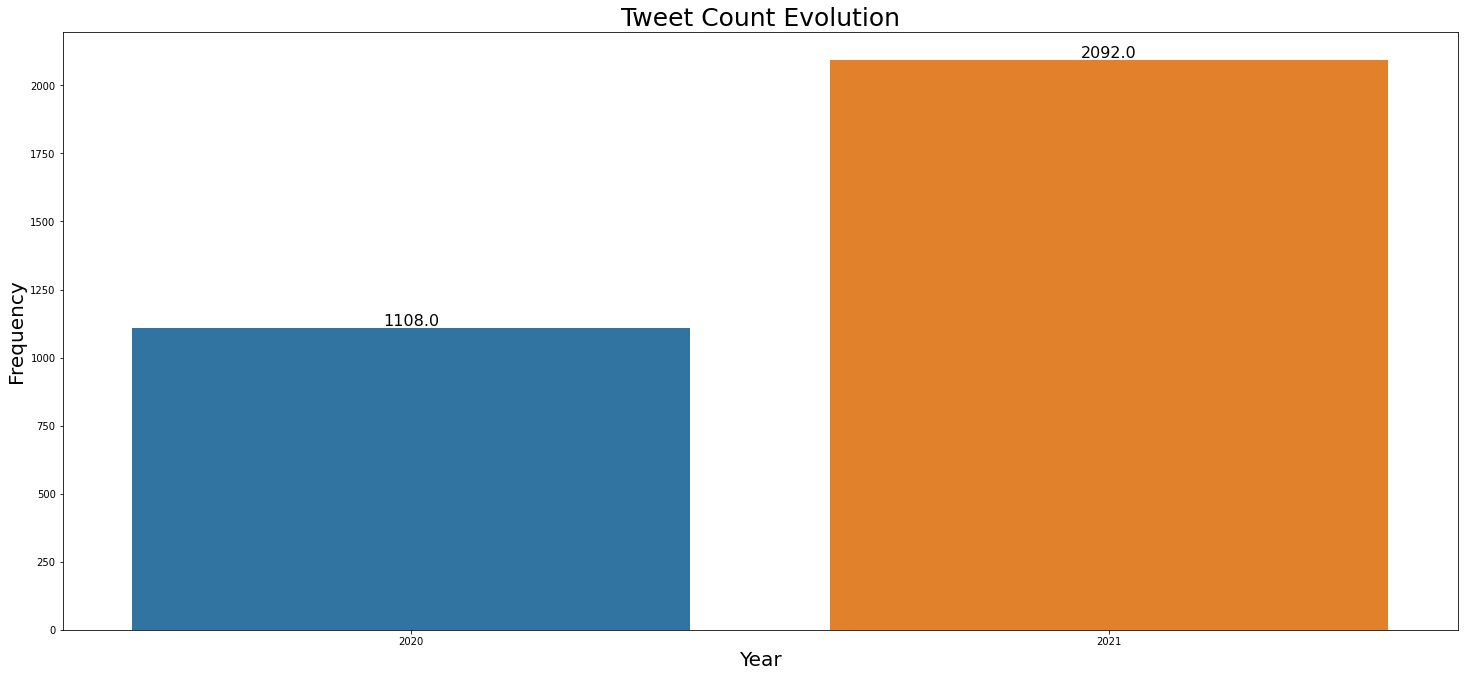

In [57]:
# Yearly evolution
date_count_df = df.groupby("year")["TweetId"].count().reset_index()
print(df['year'].unique())
# We can see that all of the 1600 Tweets are from 2020 and 2021. We can think about increasing the tweet-sample size. 
# Unfortunatly Twitter has recently updated their API and it is more cumbersome to scrape tweets. 

# Plot
plt.figure(figsize=(25, 11))
ax = sns.barplot(data=date_count_df, x="year", y="TweetId")
plt.title("Tweet Count Evolution", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Frequency", size=20)

# Add annotations
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=16)

plt.show()

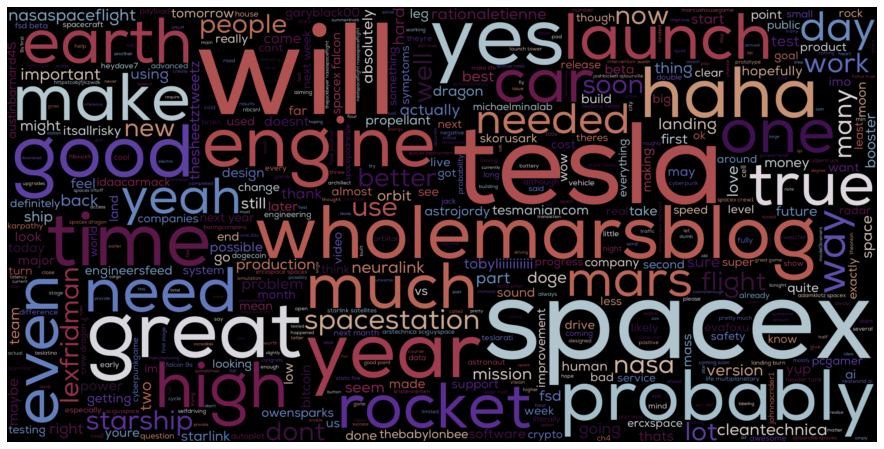

In [58]:
# Make worldcloud
# https://www.datacamp.com/tutorial/wordcloud-python
all_tweets = " ".join(token.lower() for token in df["Text"])
# all_tweets = [re.sub(r'@\w+', "", word) for word in all_tweets.split()]
all_tweets = [re.sub(r"[^a-zA-Z0-9 ]", "", word) for word in all_tweets.split()]
all_tweets = [item for item in all_tweets if item not in ['https', 't', 'amp', 'u', 'rt', 'ppathole', 'flcnhvy', 'erdayastronaut', 'teslaownerssv']]
all_tweets = " ".join(token for token in all_tweets)

stopwords_wc = set(stopwords_wc)
font_path = "../../Data/QMEF/Nexa Regular.otf"

wordcloud = WordCloud(stopwords=stopwords_wc, font_path = font_path,
                      max_words=500,
                      max_font_size=300, random_state=42,
                      width=2000, height=1000,
                      colormap = "twilight")
wordcloud.generate(all_tweets)

# Plot
plt.figure(figsize = (16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

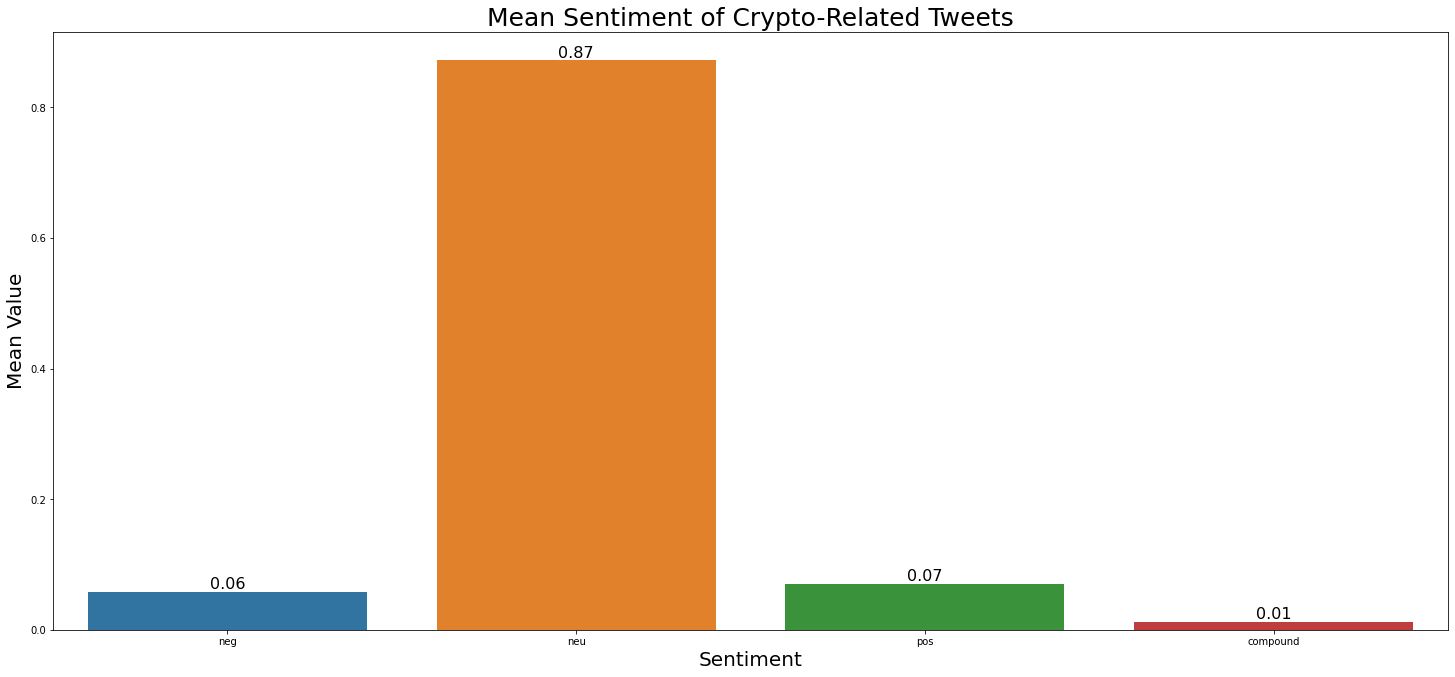

In [59]:
df_crypto = df[df['crypto related'] == 1]

# Plot
mean_values = df_crypto[['neg', 'neu', 'pos', 'compound']].mean()

# Plot
plt.figure(figsize=(25, 11))
ax = sns.barplot(x=mean_values.index, y=mean_values.values)
plt.title("Mean Sentiment of Crypto-Related Tweets", size=25)
plt.xlabel("Sentiment", size=20)
plt.ylabel("Mean Value", size=20)

# Add annotations
for p in ax.patches:
    ax.annotate(str(np.round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=16)

plt.show()

# We can see that Crypto-Related Tweets are on average more positive than negative. However, the majority of tweets don't seem to have a strong sentiment

In [60]:
print(df['CreatedAt'].min(), df['CreatedAt'].max())

2020-10-28 00:16:43+00:00 2021-05-16 05:56:47+00:00


In [61]:
df_crypto.to_csv("../../Data/QMEF/tweet_analysis.csv", sep=";", encoding='utf8')
# Problems with encoding emojis.